<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print('unique words in corpus:', data['Word'].nunique())
print('unique words in tag:', data['Tag'].nunique())

unique words in corpus: 35178
unique words in tag: 17


In [4]:
words = list(set(data['Word'].values))
words.append('ENPAD')
num_words = len(words)

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i+1 for i, w in enumerate(words)} # additional entry for padding
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'Romania': 1,
 'architectural': 2,
 'homelessness': 3,
 'writings': 4,
 'desalinization': 5,
 'advanced': 6,
 'sense': 7,
 'appreciation': 8,
 'parlimentary': 9,
 'source': 10,
 'deal': 11,
 '2,40,000': 12,
 'Altria': 13,
 'floral': 14,
 '1,600-member': 15,
 'Benghazi': 16,
 'Deauville': 17,
 'favoring': 18,
 'Here': 19,
 'Chilean': 20,
 'Tornadoes': 21,
 'Zaken': 22,
 'podium': 23,
 'deserve': 24,
 'partnered': 25,
 'drastic': 26,
 'Socialists': 27,
 'sculptures': 28,
 'dog': 29,
 'pessimist': 30,
 'plumes': 31,
 'Zvyagintsev': 32,
 'fiscal': 33,
 'Azeris': 34,
 'denials': 35,
 'Mandarin': 36,
 'living': 37,
 'Knut': 38,
 'Roma': 39,
 'brother-in-law': 40,
 'strangers': 41,
 'erosion': 42,
 'telephones': 43,
 'Ireland': 44,
 'Lennox': 45,
 'Righteous': 46,
 'inhumane': 47,
 'Poors': 48,
 'Creole': 49,
 'Padden': 50,
 'sultan': 51,
 'plenary': 52,
 'Brazilians': 53,
 'Iskan': 54,
 'spectrum': 55,
 'Giuseppe': 56,
 'send': 57,
 'Francis': 58,
 'Satriale': 59,
 'rightful': 60,
 'Annie':

### Task 5: Padding Input Sentences and Creating Train/Test Splits

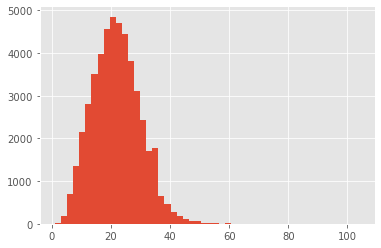

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[t[2]] for t in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

2022-02-07 23:05:53.890965: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Task 7: Train the Model

In [20]:
#pip install livelossplot
#import livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from livelossplot.tf_keras import PlotLossesCallback

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
#callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1
    )

Epoch 1/3
1080/1080 [==============================] - 83s 73ms/step - loss: 0.1882 - accuracy: 0.9575 - val_loss: 0.0649 - val_accuracy: 0.9813
Epoch 2/3
1080/1080 [==============================] - 78s 72ms/step - loss: 0.0519 - accuracy: 0.9847 - val_loss: 0.0510 - val_accuracy: 0.9847
Epoch 3/3
1080/1080 [==============================] - 77s 71ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0484 - val_accuracy: 0.9853


### Task 8: Evaluate Named Entity Recognition Model

In [23]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 11ms/step - loss: 0.0507 - accuracy: 0.9848


[0.05067979544401169, 0.9847748279571533]

In [24]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print('{:15}{:5}\t {}\n'.format("Word", "True", "Pred"))
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{:5}\t {}\n'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

The            O    	 O

United         B-geo	 B-geo

States         I-geo	 I-geo

has            O    	 O

103            O    	 O

nuclear        O    	 O

power          O    	 O

plants         O    	 O

in             O    	 O

31             O    	 B-tim

states         O    	 O

.              O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi           O    	 O

Sidi      